## ECMWF ORAS5

In this notebook, we compute seasonal mean of SST and SSS using ORAS5 ocean reanalysis product. We then compute anomaly time series in the North Atlantic for comparison against DePreSys4 Hindcasts.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [31]:
# Read Data

ppdir="../../../Data/ORAS5_Data/oras5/r1x1/"

ds_SST = []
ds_SSS = []

for r in range(0, 5):
    
    d = xr.open_mfdataset(ppdir + "sosstsst/opa" + str(r) + "/*.nc")
    ds_SST.append(d)
    
    d = xr.open_mfdataset(ppdir + "sosaline/opa" + str(r) + "/*.nc")
    ds_SSS.append(d)
    
ds_SST = xr.concat(ds_SST, dim='r')
ds_SSS = xr.concat(ds_SSS, dim='r')

ds = xr.merge([ds_SST, ds_SSS])

print(ds)

<xarray.Dataset>
Dimensions:       (lat: 180, lon: 360, r: 5, time_counter: 480)
Coordinates:
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time_counter  (time_counter) datetime64[ns] 1979-01-16 ... 2018-12-16
Dimensions without coordinates: r
Data variables:
    sosstsst      (r, time_counter, lat, lon) float32 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sosaline      (r, time_counter, lat, lon) float32 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    NCO:          4.4.6
    title:        Monthly mean 2D Sea Surface fields
    source:       ORAS5 - Ocean ReAnalysis System 5 (ECMWF)
    institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
    reference:    https://www.ecmwf.int/en/research/climate-reanalysis/ocean-...


In [42]:
# Read mask data and add gird deltas for area information
ds_mask = xr.open_dataset(ppdir + "LSM_r1x1/tmask2D_r1x1.nc")
ds_mask = ds_mask.isel(time=0, z=0) # This is to get rid of dimentions that are not requierd a size of time and z = 1. 

# Deltas to compute cell areas

RAD_EARTH = 6.387e6

d_lon, d_lat = (1.0, 1.0)

ds_mask['dx'] = ((d_lon * np.cos(ds_mask['lat'] * np.pi / 180.) 
                 * (2 * np.pi * RAD_EARTH / 360.)).expand_dims(lon=ds_mask.lon)).transpose('lat','lon')

ds_mask['dy'] = d_lat * (2 * np.pi * RAD_EARTH / 360.)
ds_mask['dy'] = ds_mask['dy'].expand_dims(lat=ds_mask.lat, lon=ds_mask.lon)

ds_mask['Area'] = ds_mask['dx'] * ds_mask['dy']

print(ds_mask)

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180)
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    time     float64 0.0
Data variables:
    tmask    (lat, lon) float32 ...
    dx       (lat, lon) float32 972.8 972.8 972.8 972.8 ... 972.8 972.8 972.8
    dy       (lat, lon) float64 1.115e+05 1.115e+05 ... 1.115e+05 1.115e+05
    Area     (lat, lon) float64 1.084e+08 1.084e+08 ... 1.084e+08 1.084e+08
Attributes:
    CDI:          Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed Apr 24 12:32:54 2019: cdo remap,r360x180,w_t_r1x1.nc tm...
    NCO:          4.6.7
    CDO:          Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/...


#### Seasonal Mean and Anomalies

First compute the mean seasonal cycle (Dec, 1979 - Feb, 2017), which is what we used for DePreSys4 hindcast. We will first focus on the DJF season for simplicity.  

Note that computing seasonal means from monthly averaged data requires assigning proper weights as the number of days are not the same for all months. Here, we follow the following example for computing seasonal mean.

http://xarray.pydata.org/en/stable/examples/monthly-means.html

In [110]:
ds1 = ds.isel(time_counter=slice(11, 458)) # Just consider Dec, 1978 to Feb, 2017

# compute mean seasonality and anomlay suing proper weights
month_length = ds1.time_counter.dt.days_in_month # get number of days in months
weights = month_length.groupby("time_counter.season") / month_length.groupby("time_counter.season").sum()

ds_clim = (ds1 * weights).groupby('time_counter.season').sum('time_counter')

ds_resam = ((ds1 * weights).resample(time_counter='QS-DEC').mean('time_counter') 
            / weights.resample(time_counter='QS-DEC').mean('time_counter'))
ds_anom = ds_resam.groupby("time_counter.season") - ds_clim
#ds_anom = ds_anom.sel(time_counter = ds_anom['time_counter.season'] == 'DJF')

# compute mean, anomaly without using weights and isolate winter seasons only
ds1_clim = (ds1).groupby('time_counter.season').mean('time_counter')

ds1_resam = ds1.resample(time_counter='QS-DEC').mean('time_counter')
ds1_anom = ds1_resam.groupby("time_counter.season") - ds1_clim
#ds1_anom = ds_anom.sel(time_counter = ds_anom['time_counter.season'] == 'DJF')

In [111]:
print(ds_anom, ds1_anom)

<xarray.Dataset>
Dimensions:       (time_counter: 149, lat: 180, lon: 360, r: 5)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-12-01 ... 2016-12-01
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    season        (time_counter) <U3 'DJF' 'MAM' 'JJA' ... 'JJA' 'SON' 'DJF'
Dimensions without coordinates: r
Data variables:
    sosstsst      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sosaline      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray> <xarray.Dataset>
Dimensions:       (time_counter: 149, lat: 180, lon: 360, r: 5)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-12-01 ... 2016-12-01
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359

In [112]:
print(ds_resam)

<xarray.Dataset>
Dimensions:       (time_counter: 149, lat: 180, lon: 360, r: 5)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-12-01 ... 2016-12-01
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Dimensions without coordinates: r
Data variables:
    sosstsst      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sosaline      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>


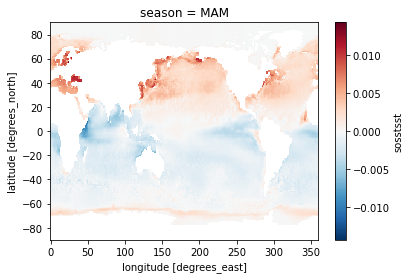

In [113]:
(ds_clim['sosstsst'].isel(r=0,season=2) - ds1_clim['sosstsst'].isel(r=0,season=2)).plot()

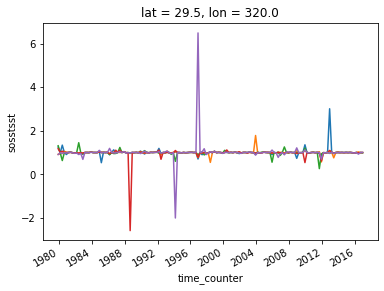

In [114]:
#ds_anom['sosstsst'].isel(r=0).sel(lat=29.5, lon=320.).plot()
#ds1_anom['sosstsst'].isel(r=0).sel(lat=29.5, lon=320.).plot()

# Just for check and mak esure that using weights does make some difference 
for i in range(0,5):
    (ds_anom['sosstsst'].isel(r=i).sel(lat=29.5, lon=320.) / 
     ds1_anom['sosstsst'].isel(r=i).sel(lat=29.5, lon=320.)).plot()

#### Area-mean anomalies in the North Atlantic

We compute area-weighted mean anomalies in the North Atlantic for comparison. For this, we choose three regions 0-40N, 40N-70N, and the whole North Atlantic. We need to create mask for North Atlamtic, so we use cmip6_prepocessing library. As seen below, mask = 0 is assinged for North Atlantic region.

/Users/hemantkhatri/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/Users/hemantkhatri/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/hemantkhatri/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms

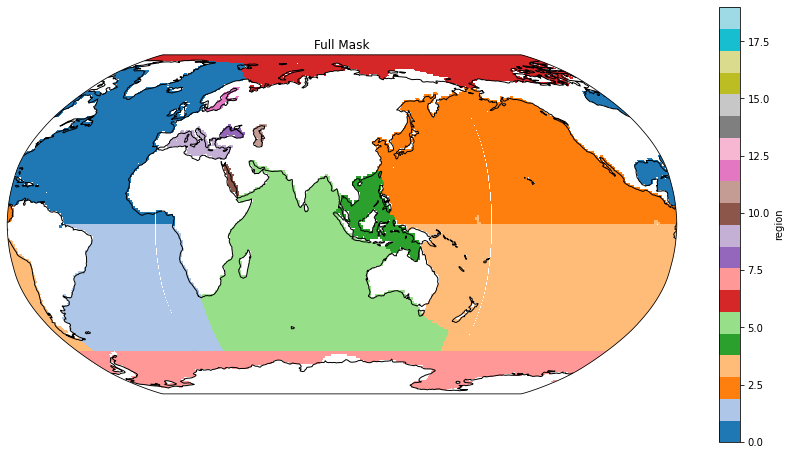

In [117]:
from cmip6_preprocessing.regionmask import merged_mask
import regionmask

basins = regionmask.defined_regions.natural_earth.ocean_basins_50

mask = merged_mask(basins, ds_mask)

import cartopy.crs as ccrs

kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), infer_intervals=False)

fig, ax = plt.subplots(ncols=1, figsize=[15,8], subplot_kw={'projection':ccrs.Robinson(100)})

mask.plot(cmap='tab20', vmin=0, vmax=19, **kwargs)
ax.set_title(f"Full Mask")
ax.coastlines()

In [120]:
# Compute are-weighted anomalies

def Compute_area_weighted_mean(ds, area, mask, lat = [0., 90.]): 
    
    tmp = ds.where(mask).sel(lat=slice(lat[0], lat[1]))
    dA = area.where(mask).sel(lat=slice(lat[0], lat[1]))
    
    tmp1 = (tmp*dA).sum(['lat', 'lon']) / dA.sum(['lat', 'lon']) 
    
    return tmp1

Trop_Anom = Compute_area_weighted_mean(ds_anom.where(ds_mask['tmask']), 
                                       ds_mask['Area'].where(ds_mask['tmask']), mask, lat = [0., 40.])

Subpolar_Anom = Compute_area_weighted_mean(ds_anom.where(ds_mask['tmask']), 
                                           ds_mask['Area'].where(ds_mask['tmask']), mask, lat = [40., 70.])

NorthAtl_Anom = Compute_area_weighted_mean(ds_anom.where(ds_mask['tmask']), 
                                           ds_mask['Area'].where(ds_mask['tmask']), mask, lat = [0., 80.])

In [126]:
Trop_Anom = Trop_Anom.compute()
Subpolar_Anom = Subpolar_Anom.compute()
NorthAtl_Anom = NorthAtl_Anom.compute()

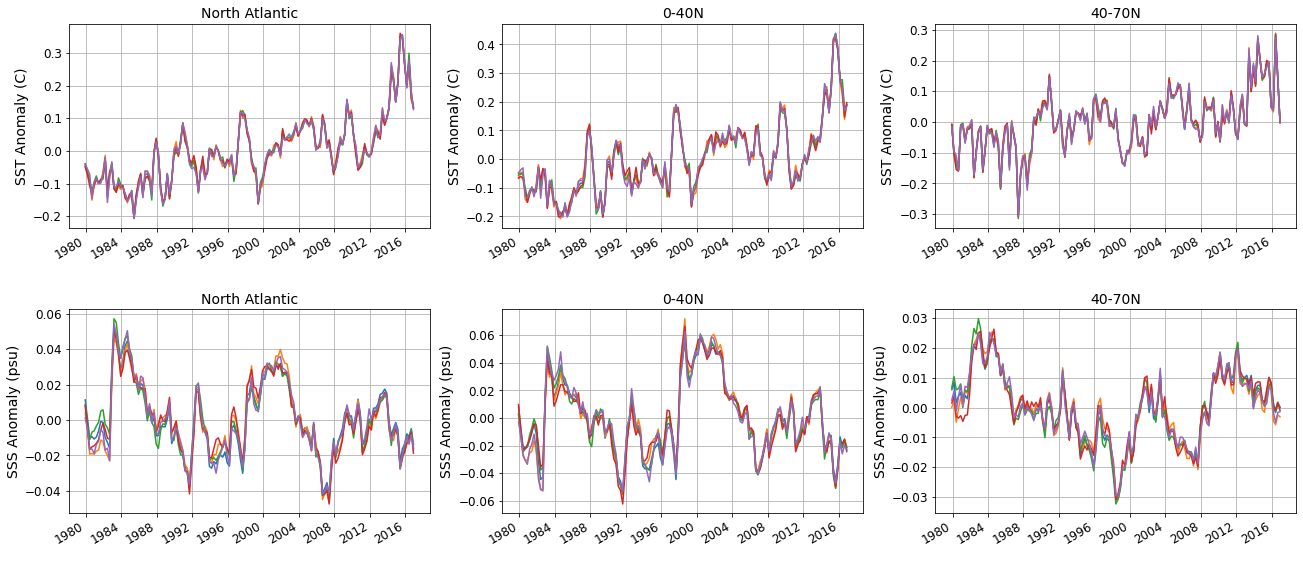

In [135]:
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[22,9])

ax = fig.add_subplot(grid[0, 0])
for i in range(0,5):
    NorthAtl_Anom['sosstsst'].isel(r=i).plot()
    ax.set_ylabel(r'SST Anomaly (C)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('North Atlantic', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[0, 1])
for i in range(0,5):
    Trop_Anom['sosstsst'].isel(r=i).plot()
    ax.set_ylabel(r'SST Anomaly (C)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('0-40N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[0, 2])
for i in range(0,5):
    Subpolar_Anom['sosstsst'].isel(r=i).plot()
    ax.set_ylabel(r'SST Anomaly (C)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('40-70N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[1, 0])
for i in range(0,5):
    NorthAtl_Anom['sosaline'].isel(r=i).plot()
    ax.set_ylabel(r'SSS Anomaly (psu)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('North Atlantic', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[1, 1])
for i in range(0,5):
    Trop_Anom['sosaline'].isel(r=i).plot()
    ax.set_ylabel(r'SSS Anomaly (psu)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('0-40N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[1, 2])
for i in range(0,5):
    Subpolar_Anom['sosaline'].isel(r=i).plot()
    ax.set_ylabel(r'SSS Anomaly (psu)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('40-70N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)

In [124]:
Trop_Anom

<xarray.Dataset>
Dimensions:       (time_counter: 149, r: 5)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-12-01 ... 2016-12-01
    season        (time_counter) <U3 'DJF' 'MAM' 'JJA' ... 'JJA' 'SON' 'DJF'
    time          float64 0.0
Dimensions without coordinates: r
Data variables:
    sosstsst      (time_counter, r) float64 -0.05751 -0.06325 ... 0.1969 0.1835
    sosaline      (time_counter, r) float64 0.008016 0.003417 ... -0.02338